<a href="https://colab.research.google.com/github/KAREN154/PlantPathoDetect-/blob/main/Maize_Classification_Inception_%26_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Building A CNN Model to Classify Tomato Images
>Tomato plants can exhibit various diseases and deficiencies that affect crop yield and quality. Accurately categorizing tomato plant conditions through leaf images is essential for effective crop management and disease control. By leveraging CNNs, the classification process can be automated, significantly improving the efficiency and accuracy of disease detection and plant health monitoring strategies.
CNNs excel at image analysis and feature extraction, allowing them to capture intricate details and patterns from tomato leaf images in the dataset.

**The convolutional layers in CNNs are able to identify:**
- Leaf color variations
- Spot patterns and lesions
- Texture changes
- Leaf venation patterns
- Disease-specific markings
- Nutrient deficiency symptoms

>These features enable the network to learn and distinguish between different tomato plant conditions. The pooling layers nested throughout the architecture down-sample the produced feature maps, allowing models to generalize leaf characteristics across different:

- Lighting conditions
- Leaf orientations
- Growth stages
- Image angles
- Environmental factors

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

class FastInceptionV3:
    def __init__(self, input_shape=(150, 150, 3), num_classes=3):  # Reduced input size, 3 classes
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze base model layers to speed up training
        for layer in base_model.layers:
            layer.trainable = False

        # Custom layers (Reduced complexity)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)  # Reduced from 512 to 256
        x = Dropout(0.3)(x)  # Reduced dropout from 0.5 to 0.3
        predictions = Dense(self.num_classes, activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=predictions)

        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train_model(self, train_dir, val_dir, batch_size=128, epochs=5):  # Larger batch size, fewer epochs
        if self.model is None:
            self.build_model()

        IMAGE_SIZE = self.input_shape[:2]

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,  # Reduced for speed
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir, target_size=IMAGE_SIZE, batch_size=batch_size, class_mode='categorical'
        )
        val_generator = val_datagen.flow_from_directory(
            val_dir, target_size=IMAGE_SIZE, batch_size=batch_size, class_mode='categorical'
        )

        if train_generator.num_classes != self.num_classes:
            raise ValueError(f"Mismatch: Dataset has {train_generator.num_classes} classes, but model expects {self.num_classes}")

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, min_lr=1e-5)

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=[early_stopping, reduce_lr]
        )

    def evaluate_model(self, test_dir, batch_size=128):
        if self.model is None:
            raise ValueError("Build and train the model first.")

        IMAGE_SIZE = self.input_shape[:2]
        test_datagen = ImageDataGenerator(rescale=1./255)

        test_generator = test_datagen.flow_from_directory(
            test_dir, target_size=IMAGE_SIZE, batch_size=batch_size, class_mode='categorical'
        )

        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

# Instantiate and run the optimized model
fast_model = FastInceptionV3()

# Build the model
fast_model.build_model()

# Define directories
train_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Train_augmented'
val_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Val'
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Test'

# Train with optimized parameters (should finish within 1 hour)
fast_model.train_model(train_dir, val_dir, batch_size=128, epochs=5)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 13182 images belonging to 3 classes.
Found 1216 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 4413s 43s/step - accuracy: 0.8183 - loss: 0.5080 - val_accuracy: 0.8561 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.9156 - loss: 0.2233 - val_accuracy: 0.9038 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.9192 - loss: 0.2091 - val_accuracy: 0.8816 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.9295 - loss: 0.1819 - val_accuracy: 0.8882 - val_loss: 0.2939 - learning_rate: 0.0010
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.9326 - loss: 0.1717 - val_accuracy: 0.9087 - val_loss: 0.2282 - learning_rate: 3.0000e-04


In [ ]:
class InceptionV3Model:
    def __init__(self, input_shape=(224, 224, 3), num_classes=6):  # Changed default to 6
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def save_model(self, filepath): # Added save_model method to the InceptionV3Model class
        """Saves the trained model to the specified filepath."""
        self.model.save(filepath) # Saves the model using the Keras save method

In [ ]:
# Instantiate the model
inception_model = InceptionV3Model()

In [ ]:
fast_model.model.save('Maize_inception_model.h5')


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('Maize_inception_model.h5')

# Define image size and batch size - Match the training input size
IMAGE_SIZE = (150, 150)  # Changed to (150, 150) to match the model's input shape
BATCH_SIZE = 32

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,  # Using the correct image size
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

Found 136 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step
Weighted F1 Score: 0.89
                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.97      0.71      0.82        41
             Healthy       0.98      1.00      0.99        47
Northern Leaf Blight       0.79      0.96      0.87        48

            accuracy                           0.90       136
           macro avg       0.91      0.89      0.89       136
        weighted avg       0.91      0.90      0.89       136



Found 13182 images belonging to 3 classes.
Found 1216 images belonging to 3 classes.
Detected 3 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3171s 15s/step - accuracy: 0.7889 - loss: 0.5110 - val_accuracy: 0.9334 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2961s 14s/step - accuracy: 0.9253 - loss: 0.1988 - val_accuracy: 0.9276 - val_loss: 0.1764 - learning_rate: 8.9125e-04
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2936s 14s/step - accuracy: 0.9349 - loss: 0.1644 - val_accuracy: 0.9334 - val_loss: 0.1629 - learning_rate: 7.9433e-04
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2907s 14s/step - accuracy: 0.9405 - loss: 0.1573 - val_accuracy: 0.9334 - val_loss: 0.1501 - learning_rate: 7.0795e-04
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2897s 14s/step - accuracy: 0.9461 - loss: 0.1423 - val_accuracy: 0.9309 - val_loss: 0.1813 - learning_rate: 6.3096e-04
Found 136 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9304 - loss: 0.1624


Test Accuracy: 0.93
Model saved to /content/drive/MyDrive/densenet121_model.h5


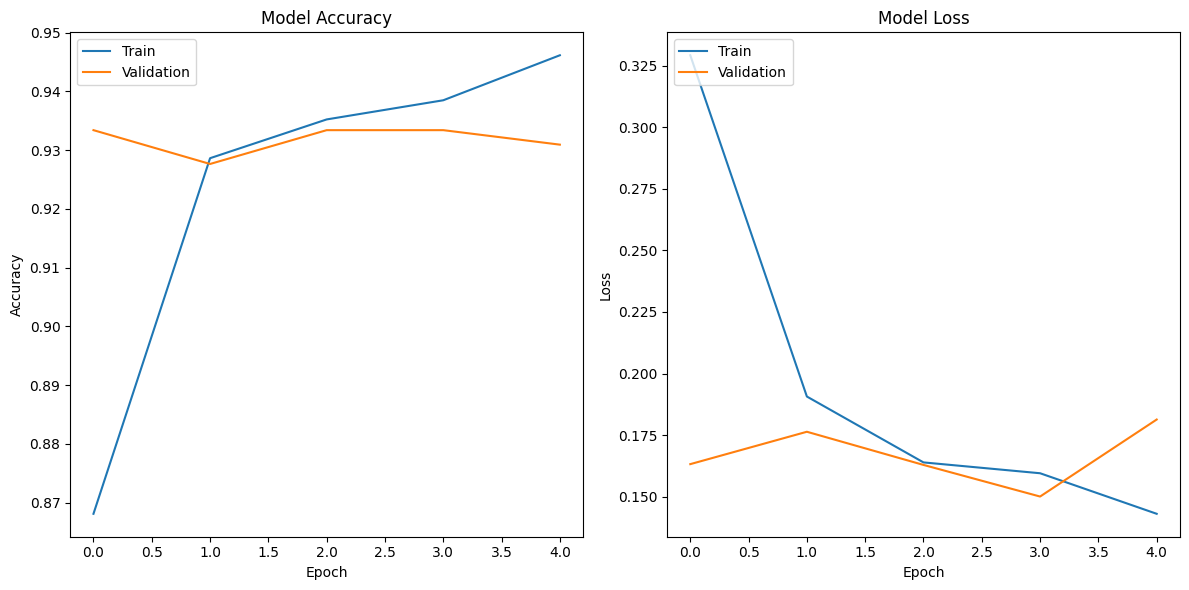

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt

class DenseNet121Model:
    def __init__(self, input_shape=(224, 224, 3), num_classes=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        """Build the DenseNet121 model with dynamically determined num_classes."""
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)  # Dynamic number of classes

        # Create and compile model
        self.model = Model(inputs=base_model.input, outputs=predictions)
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def fine_tune_model(self, fine_tune_at=100):
        """Unfreeze top layers and recompile the model for fine-tuning."""
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in self.model.layers[fine_tune_at:]:
            layer.trainable = True

        self.model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, train_dir, val_dir, batch_size=32, epochs=20):
        """Train the model with data augmentation and callbacks."""
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generators
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Dynamically adjust num_classes based on dataset
        self.num_classes = train_generator.num_classes
        print(f"Detected {self.num_classes} classes.")
        self.build_model()  # Rebuild model with correct num_classes

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)
        lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))

        # Train model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=[early_stopping, reduce_lr, lr_scheduler]
        )

    def evaluate_model(self, test_dir, batch_size=32):
        """Evaluate the model on test data."""
        IMAGE_SIZE = self.input_shape[:2]

        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

    def save_model(self, file_path):
        """Save the trained model."""
        self.model.save(file_path)
        print(f"Model saved to {file_path}")

    def plot_training_history(self):
        """Plot training accuracy and loss curves."""
        if self.history:
            plt.figure(figsize=(12, 6))

            # Accuracy plot
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['accuracy'])
            plt.plot(self.history.history['val_accuracy'])
            plt.title('Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            # Loss plot
            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            plt.tight_layout()
            plt.show()
        else:
            print("No training history found. Please train the model first.")

# Instantiate model
densenet_model = DenseNet121Model()

# Define dataset directories
train_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Train_augmented'
val_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Val'
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test'

# Train the model
densenet_model.train_model(train_dir, val_dir, batch_size=64, epochs=5)

# Evaluate the model
densenet_model.evaluate_model(test_dir)

# Save the model
densenet_model.save_model('/content/drive/MyDrive/densenet121_model.h5')

# Plot training history
densenet_model.plot_training_history()


In [4]:
# Save the model
densenet_model.save_model('maize_densenet_model.h5')

Model saved to maize_densenet_model.h5


In [6]:
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('maize_densenet_model.h5')

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test'
# Corn (Maize)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

Found 136 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step
Weighted F1 Score: 0.93
                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.92      0.83      0.87        41
             Healthy       1.00      1.00      1.00        47
Northern Leaf Blight       0.87      0.94      0.90        48

            accuracy                           0.93       136
           macro avg       0.93      0.92      0.92       136
        weighted avg       0.93      0.93      0.93       136

